In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import Dataset
from src.modelling import DeepModel_Trainer
import torch.utils.data
import torch
import wandb
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import seaborn as sns


plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')

In [2]:
file_name_zueri = r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
# file_name_zueri = r'C:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
random_state = 123
np.random.seed(random_state)

def load_data_train(model_trainer,eval_mode=False):
    #     # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []
    all_data_field_instance = []
    # Iterate through the DataLoader
    for batch in model_trainer.train_loader:
        if eval_mode:
            input, _, target_2, _, gt_instance = batch
            all_data_input.append(input)
            all_data_target.append(target_2)
            all_data_field_instance.append(gt_instance)
        else:
            input, _, target_2, _ = batch
            all_data_input.append(input)
            all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_train = torch.cat(all_data_input, dim=0)
    target_train = torch.cat(all_data_target, dim=0)
    if eval_mode:
        field_instance_train = torch.cat(all_data_field_instance, dim=0)
        return input_train,target_train,field_instance_train
    return input_train,target_train

def load_data_test(model_trainer):
    #     # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []
    # Iterate through the DataLoader
    for batch in model_trainer.test_loader:
        input, _, target_2, _ = batch

        all_data_input.append(input)
        all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_test = torch.cat(all_data_input, dim=0)
    target_test= torch.cat(all_data_target, dim=0)
    return input_test,target_test

def prepare_data_fold(input,target):
    reshape_factor = len(input) // 10 
    input= input[0:reshape_factor*10]
    target = target[0:reshape_factor*10]
    reshaped_tensor = input.reshape(24*reshape_factor, 24*10, 4)
    reshaped_target = target.reshape(24*reshape_factor, 24*10)

    return reshaped_tensor,reshaped_target




In [3]:
trainer = DeepModel_Trainer(r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5', 'labels.csv', None, 'cpu',temporal_sampling=True)
trainer.create_loader()

5fold:  3   Mode:  test
Dataset size:  27977
Valid dataset size:  4477
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  4   Mode:  test
Dataset size:  27977
Valid dataset size:  1119
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


In [4]:
input_train,target_train = load_data_train(trainer)
reshaped_tensor_train, reshaped_target_train = prepare_data_fold(input_train,target_train)

input_test,target_test= load_data_test(trainer)
reshaped_tensor_test, reshaped_target_test = prepare_data_fold(input_test,target_test)

## Labels

### Distribution Overall

C:\Users\Tom\AppData\Local\Temp\ipykernel_12880\2083155085.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(value_labels_level_1)


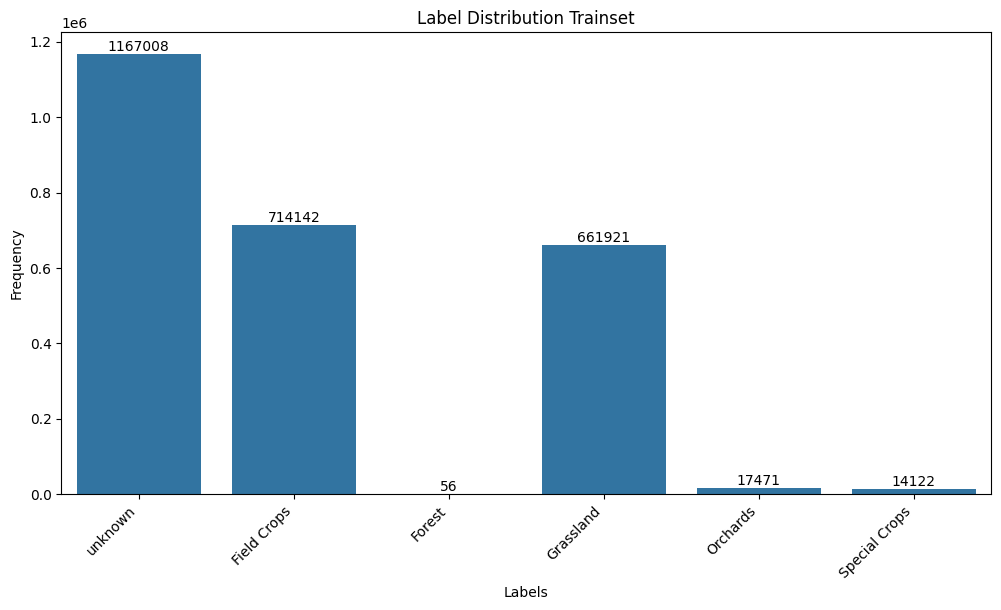

In [5]:
x_values, y_values = reshaped_target_train.flatten().unique(return_counts=True)

x_np = x_values.numpy()
y_np = y_values.numpy()
value_labels_level_1 = ['unknown','Field Crops','Forest','Grassland','Orchards','Special Crops']
ax = sns.barplot(x=x_np, y=y_np)

# Add value labels to the bars
for i, v in enumerate(y_np):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10)

# Set plot labels and title
plt.title('Label Distribution Trainset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
ax.set_xticklabels(value_labels_level_1)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [6]:
# class distribution in percent trainset
np.round(y_np / len(reshaped_target_train.flatten())*100,2)

array([45.33, 27.74,  0.  , 25.71,  0.68,  0.55])

C:\Users\Tom\AppData\Local\Temp\ipykernel_12880\1108327787.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(value_labels_level_1)


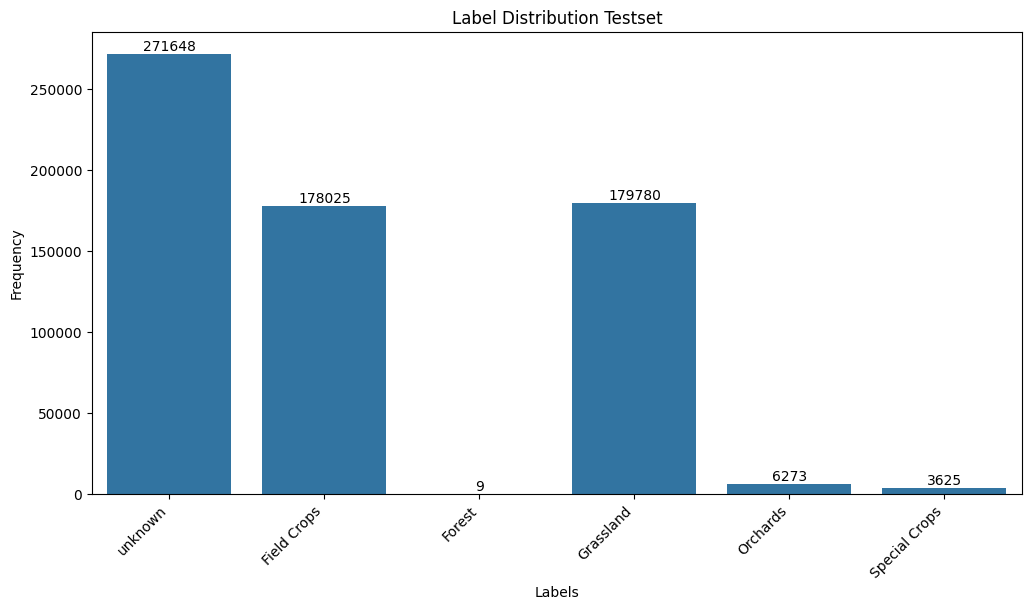

In [7]:
x_values, y_values = reshaped_target_test.flatten().unique(return_counts=True)

value_labels_level_1 = ['unknown','Field Crops','Forest','Grassland','Orchards','Special Crops']
x_np = x_values.numpy()
y_np = y_values.numpy()

# Create a bar plot using Seaborn
ax = sns.barplot(x=x_np, y=y_np)

# Add value labels to the bars
for i, v in enumerate(y_np):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10)

# Set plot labels and title
plt.title('Label Distribution Testset')
plt.xlabel('Labels')
plt.ylabel('Frequency')
ax.set_xticklabels(value_labels_level_1)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [8]:
# class distribution in percent testset
np.round(y_np / len(reshaped_target_test.flatten())*100,2)

array([42.49, 27.84,  0.  , 28.12,  0.98,  0.57])

### Distribution Fields

In [9]:
trainer.create_loader(eval_mode=True)

5fold:  3   Mode:  test
Dataset size:  27977
Valid dataset size:  4477
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
5fold:  4   Mode:  test
Dataset size:  27977
Valid dataset size:  1119
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20


In [10]:
input_train,target_train,field_instance_train = load_data_train(trainer,eval_mode=True)
target_train_array = target_train.flatten().numpy()
field_instance_train_array = field_instance_train.flatten().numpy()

# Create a DataFrame
df = pd.DataFrame({
    'Target': target_train_array,
    'Field_Instance': field_instance_train_array
})
# Group by 'Target' and count the occurrences of each 'Field_Instance'
value_counts_per_target = df.groupby('Target')['Field_Instance'].value_counts()
# Convert the Series to a DataFrame
result_df = value_counts_per_target.reset_index(name='Count')
# Pivot the DataFrame to have 'Field_Instance' values as columns
pivot_df = result_df.pivot(index='Target', columns='Field_Instance', values='Count').fillna(0)

In [11]:
pivot_df

Field_Instance,0,48204,98321,98322,98334,98342,98344,98355,98356,98369,...,253614,253640,253642,253654,253658,253659,253663,253673,253680,253686
Target,,,,,,,,,,,,,,,,,,,,,
0,1147718.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,2274.0,0.0,83.0,53.0,234.0,210.0,43.0,270.0,152.0,0.0,...,0.0,265.0,0.0,0.0,0.0,0.0,0.0,215.0,257.0,92.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3849.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,102.0,235.0,115.0,17.0,238.0,0.0,0.0,0.0
4,123.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Channel Distribution

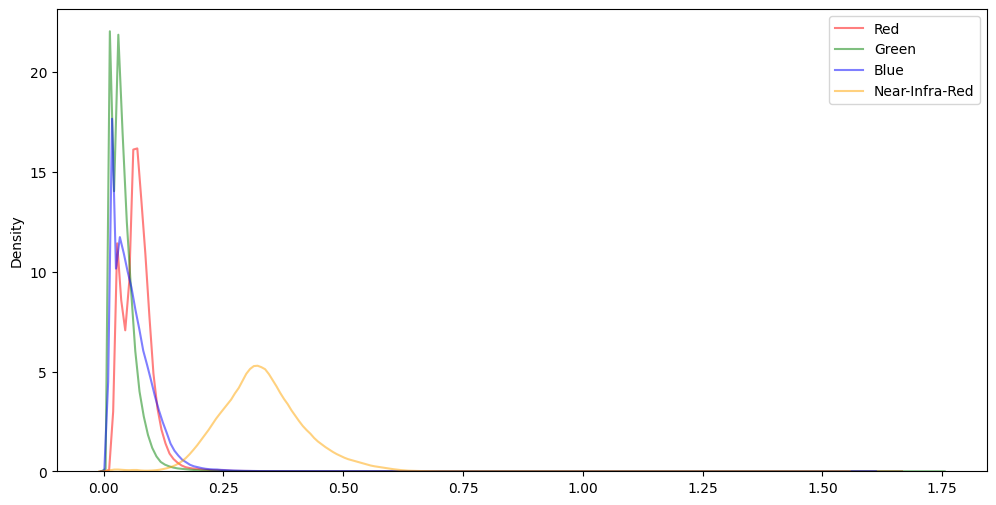

In [12]:
# RGB-NIR
sns.kdeplot(input_train[:,:,1,:,:].flatten().numpy(),color="red",label="Red",alpha=0.5)
sns.kdeplot(input_train[:,:,2,:,:].flatten().numpy(),color="green",label="Green",alpha=0.5)
sns.kdeplot(input_train[:,:,3,:,:].flatten().numpy(),color="blue",label="Blue",alpha=0.5)
sns.kdeplot(input_train[:,:,0,:,:].flatten().numpy(),color="orange",label="Near-Infra-Red",alpha=0.5)
plt.legend()

## Example Fields   

In [13]:
reshaped_tensor,reshaped_target = prepare_data_fold(input_train,target_train)

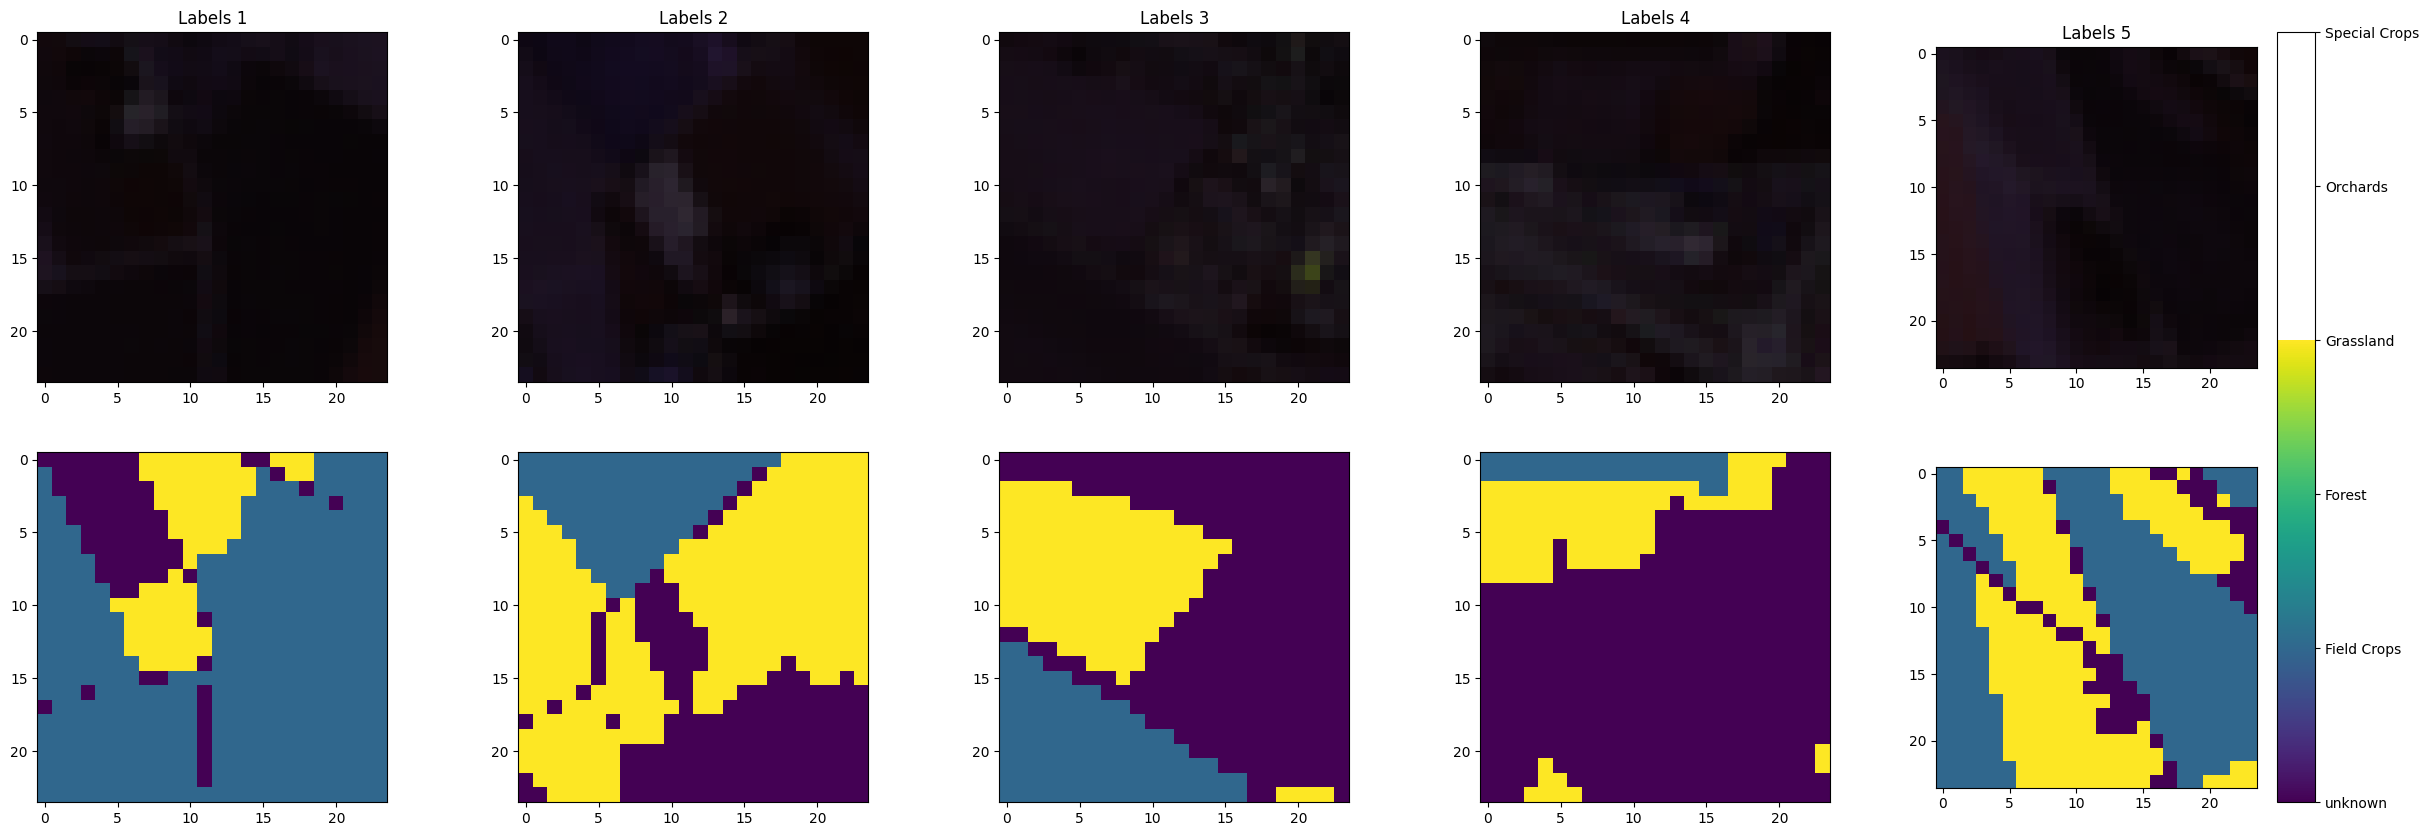

In [30]:
# Plotting
fig, axs = plt.subplots(2, 5, figsize=(30, 10))  # Updated to 6 rows
# Your labels
label_mapping = {i:v for i,v in enumerate(value_labels_level_1)}
# Plot 5 more random samples
for i in range(0, 5):
    random_index = random_index = np.random.randint(0, len(input_train))
    rgb_image = input_train[random_index]
    labels = target_train[random_index]
    rgb_channels = rgb_image[:, [1, 2, 3], :, :]
    # Make sure the tensor is in the range [0, 1]
    rgb_channels = torch.clamp(rgb_channels, 0, 1)
    # Plot RGB image
    rgb_image_to_plot = rgb_channels.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    # print(rgb_image_to_plot)
    axs[0, i].imshow(rgb_image_to_plot,cmap='gray')
    axs[0, i].set_title(f'RGB Image {i+1}')

    # Plotting
    img = axs[1, i].imshow(labels.cpu().detach().numpy(), cmap='viridis')
    axs[0, i].set_title(f'Labels {i+1}')


# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])  # Adjust the shrink parameter as needed
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()))
# Show the plots
plt.show()



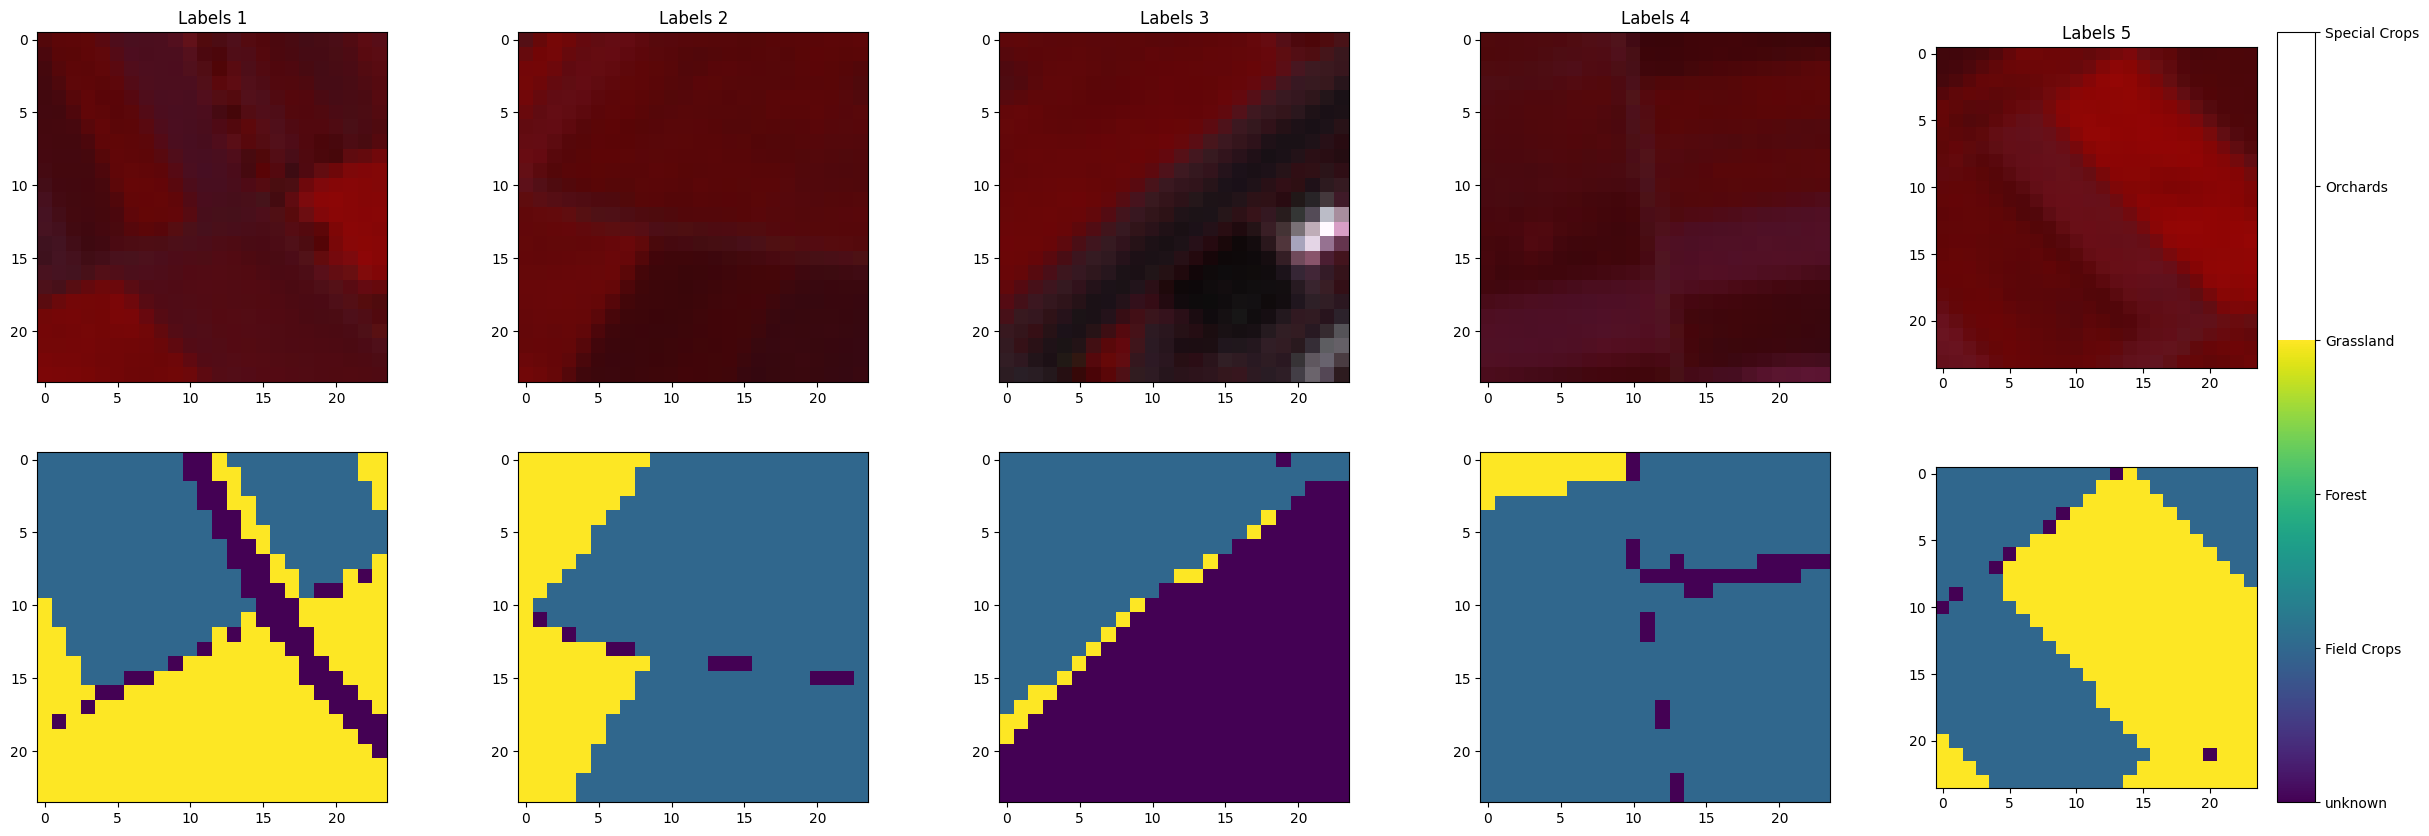

In [29]:
# Plotting
fig, axs = plt.subplots(2, 5, figsize=(30, 10))  # Updated to 6 rows
# Your labels
label_mapping = {i:v for i,v in enumerate(value_labels_level_1)}
# Plot 5 more random samples
for i in range(0, 5):
    random_index = random_index = np.random.randint(0, len(input_train))
    rgb_image = input_train[random_index]
    labels = target_train[random_index]
    rgb_channels = rgb_image[:, [0, 2, 3], :, :]
    # Make sure the tensor is in the range [0, 1]
    rgb_channels = torch.clamp(rgb_channels, 0, 1)
    # Plot RGB image
    rgb_image_to_plot = rgb_channels.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    axs[0, i].imshow(rgb_image_to_plot,cmap='gray')
    axs[0, i].set_title(f'RGB Image {i+1}')

    # Plotting
    img = axs[1, i].imshow(labels.cpu().detach().numpy(), cmap='viridis')
    axs[0, i].set_title(f'Labels {i+1}')


# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])  # Adjust the shrink parameter as needed
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()))

plt.show()



### Tile Characteristics    

In [16]:
targets_per_tile = []
pixel_class_per_tile = []
for i in range(target_train.size(0)):
    # get unique targets
    unique_targets_tile,targets_counts_tile = target_train[i].unique(return_counts=True)
    targets_per_tile.append(len(unique_targets_tile))

    missing_values = []
    for i in range(len(unique_targets_tile) - 1):
        diff = unique_targets_tile[i + 1] - unique_targets_tile[i]
        if diff > 1:
            # Insert the missing values up to the next value in unique_targets_tile
            missing_values.extend(range(unique_targets_tile[i] + 1, min(unique_targets_tile[i + 1], 6)))

        # Insert the missing values up to 5 if needed
    last_value = unique_targets_tile[-1].item() if len(unique_targets_tile) > 0 else 0
    missing_values.extend(range(last_value + 1, 6))
    # Check if zero is missing
    if unique_targets_tile[0].item() != 0:
        missing_values.append(0)
    new_tensor1 = torch.cat((unique_targets_tile[:1], torch.tensor(missing_values), unique_targets_tile[1:]))
    new_tensor2 = torch.cat((targets_counts_tile[:1], torch.zeros(len(missing_values)), targets_counts_tile[1:]))
    sorted_indices = torch.argsort(new_tensor1, descending=False)
    new_tensor1 = new_tensor1[sorted_indices]
    new_tensor2 = new_tensor2[sorted_indices]

    pixel_class_per_tile.append((new_tensor2 /(24*24)*100))

In [17]:
print(f"Average Targets per 24x24 Pixel Tile:\n{np.round(np.array(targets_per_tile).mean(),3)}")

Average Targets per 24x24 Pixel Tile:
3.02


In [18]:
stacked_tensor = torch.stack(pixel_class_per_tile)
column_means = torch.mean(stacked_tensor, dim=0)

values ={value_labels_level_1[i]:v for i,v in enumerate( np.round(column_means.numpy(),2))}

print(f"Average Class Area % per 24x24 Pixel Tile:\n{values}")

Average Class Area % per 24x24 Pixel Tile:
{'unknown': 45.3, 'Field Crops': 27.78, 'Forest': 0.0, 'Grassland': 25.69, 'Orchards': 0.68, 'Special Crops': 0.55}


### Field Characteristics

In [19]:
fields_per_tile = []
pixel_class_per_tile = []
for i in range(target_train.size(0)):
    # get unique targets
    unique_fields_tile,fields_counts_tile = field_instance_train[i].unique(return_counts=True)
    fields_per_tile.append(len(unique_fields_tile))

In [20]:
print(f"Average Fields per 24x24 Pixel Tile:\n{np.round(np.array(fields_per_tile).mean(),3)}")

Average Fields per 24x24 Pixel Tile:
9.577


In [21]:
unique_fields_tile,fields_counts_tile = field_instance_train.flatten().unique(return_counts=True)
#remove the 0
unique_fields_tile= unique_fields_tile[1:]
fields_counts_tile= fields_counts_tile[1:]

In [22]:
sorted_indices = torch.argsort(fields_counts_tile, descending=True)
unique_fields_tile = unique_fields_tile[sorted_indices]
fields_counts_tile = fields_counts_tile[sorted_indices]

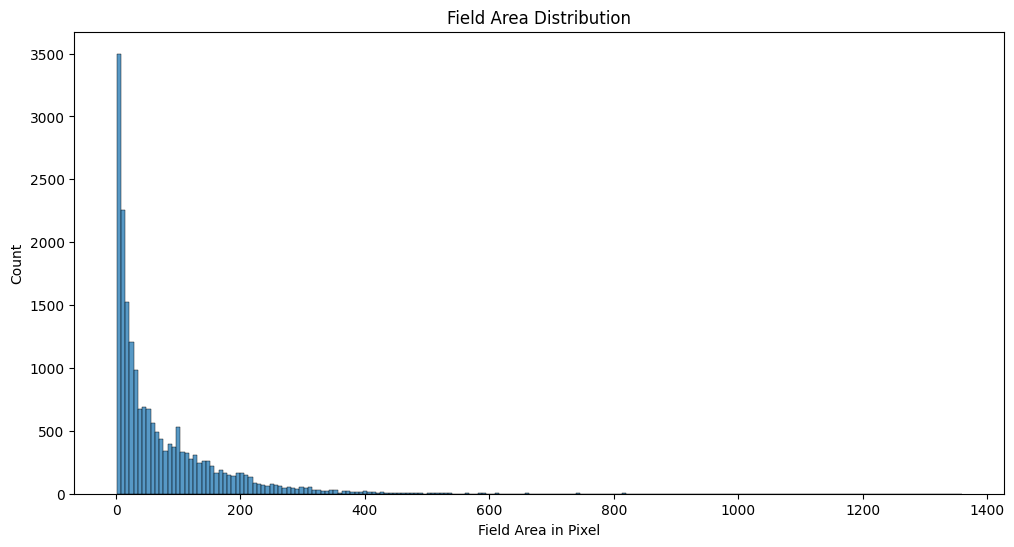

In [23]:
sns.histplot(fields_counts_tile)
plt.title('Field Area Distribution')
plt.xlabel('Field Area in Pixel')
plt.show()

### Fields

In [137]:
field = unique_fields_tile[500].numpy().max()
field

206225

In [138]:
tensor_for_data = []
tensor_for_field = []
tensor_for_target = []
for i in range(target_train.size(0)):
    has_value_field = torch.any(field_instance_train[i] == field).item()
    if has_value_field:
        tensor_for_data.append(input_train[i])
        tensor_for_field.append(field_instance_train[i])
        tensor_for_target.append(target_train[i])

In [139]:
tensor_for_field =torch.stack(tensor_for_field).view(-1,24*len(tensor_for_field),24)
tensor_for_field.shape

tensor_for_target =torch.stack(tensor_for_target).view(-1,24*len(tensor_for_target),24)
tensor_for_target.shape

tensor_for_data =torch.stack(tensor_for_data)
tensor_for_data= tensor_for_data[:,:,1:4,:,:]
image_tensor = tensor_for_data  # Example random tensor
image_tensor = torch.clamp(image_tensor, 0, 1)
stacked_image = torch.cat([image_tensor[i] for i in range(image_tensor.size(0))], dim=3)

stacked_image = stacked_image.squeeze().permute(2, 1, 0).numpy()
stacked_image.shape

(96, 24, 3)

In [140]:
label_mapping_fields = {v:v for i,v in enumerate(tensor_for_field[0].unique().numpy())}
if 0 in label_mapping_fields:
    del label_mapping_fields[0]

In [142]:
label_mapping_fields = {field:field}

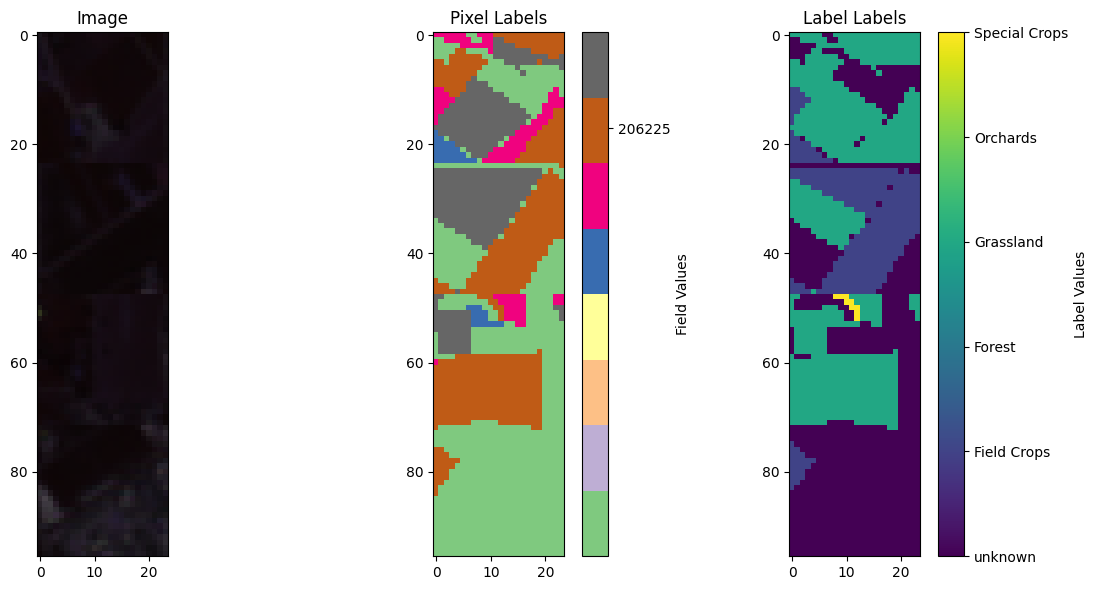

In [146]:
# Plot the image
plt.subplot(1, 3, 1)
plt.imshow(stacked_image)
plt.title('Image')

# Plot the pixel labels
ax1 =plt.subplot(1, 3, 2)
im1=plt.imshow(tensor_for_field[0],cmap='Accent')  # Assuming grayscale labels
plt.title('Pixel Labels')
cbar = plt.colorbar(im1, ax=ax1)
cbar.set_label('Field Values')
cbar.set_ticks(list(label_mapping_fields.keys()))
cbar.set_ticklabels(list(label_mapping_fields.values()))



# Plot the pixel labels
ax = plt.subplot(1, 3, 3)
im = plt.imshow(tensor_for_target[0],)  # Assuming grayscale labels
plt.title('Label Labels')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Label Values')
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()))
plt.tight_layout()

# Show the plot
plt.show()

tensor([     0, 153402, 154119, 161533, 166353, 176054, 179079, 180111, 189383,
        195401, 195986, 199297, 206225, 210229, 215274, 230479, 233581, 233960,
        242067, 245994, 251243, 252360])

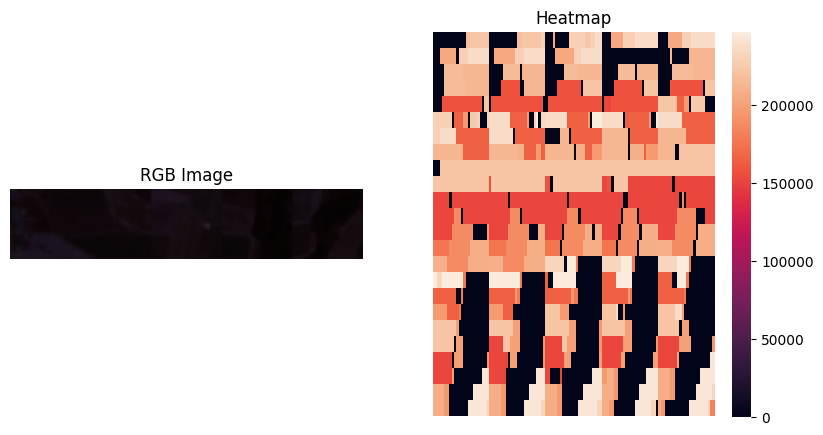

In [45]:
import torch
import matplotlib.pyplot as plt


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the stacked RGB image
ax1.imshow(stacked_image)
ax1.axis('off')  # Turn off axis labels for better visualization
ax1.set_title('RGB Image')

# Plot the heatmap
sns.heatmap(tensor_for_field.squeeze().numpy(), ax=ax2)
ax2.axis('off')  # Turn off axis labels for better visualization
ax2.set_title('Heatmap')

# Add colorbar for the entire figure
cbar = fig.colorbar(img, ax=axs[:, -1])  # Adjust the shrink parameter as needed
cbar.set_ticks(list(label_mapping.keys()))
cbar.set_ticklabels(list(label_mapping.values()))

plt.show()